In [131]:
import spacy

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
import hdbscan
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

import string
import time
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]

In [94]:
def load20NewsGroups():
    # #############################################################################
    # Load some categories from the training set
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
     ]
    dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)
    print("%d documents" % len(dataset.data))
    print("%d categories" % len(dataset.target_names))
    return dataset.data

In [95]:
###########create data clearner

#Custom transformer using spaCy 
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    # lowercase
    text = text.lower()
    return text

In [96]:
############create tokenizer

#Create spacy tokenizer that parses a sentence and generates tokens
#these can also be replaced by word vectors 
# List of symbols we don't care about
punctuations = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]
parser = spacy.load('en')
def tokenizeText(sentence):
    tokens = parser(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]  
    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    return tokens

In [102]:
##########Create preprocess pipline and run
def preProcessData(X_train):
    #create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
    vectorizer = TfidfVectorizer(tokenizer = tokenizeText)
    svd = TruncatedSVD(2)
    #normalizer = Normalizer(copy=False)
    start_time = time.time()
    pipe_preprocess = Pipeline([("cleaner", CleanTextTransformer()),
                 ("vectorizer", vectorizer),
                 ("svd", svd)])
    X_train_preprocess = pipe_preprocess.fit_transform(X_train)
    end_time = time.time()
    print("Preprocess done in {} Seconds".format(end_time - start_time))
    return X_train_preprocess

In [103]:
######### visualize two dimensional cluster 
def visualizeCluster(x1, x2, colors):
    plt.scatter(x1, x2, c=colors, s=50, linewidths=0.5, alpha=0.7)
    plt.show()

3387 documents
4 categories


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Preprocess done in 247.91891503334045 Seconds
Trained DBSCAN model in 0.4928157329559326 Seconds
#of labels 8,
labels:[0 0 0 ... 0 0 0]


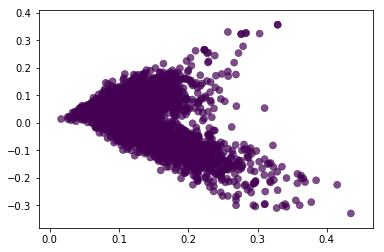

In [107]:
###########Training model 1:DBSCAN
X_train = load20NewsGroups()
X_train_preprocess = preProcessData(X_train)

Trained DBSCAN model in 0.5074090957641602 Seconds
#of labels 1,
labels:[0 0 0 ... 0 0 0]


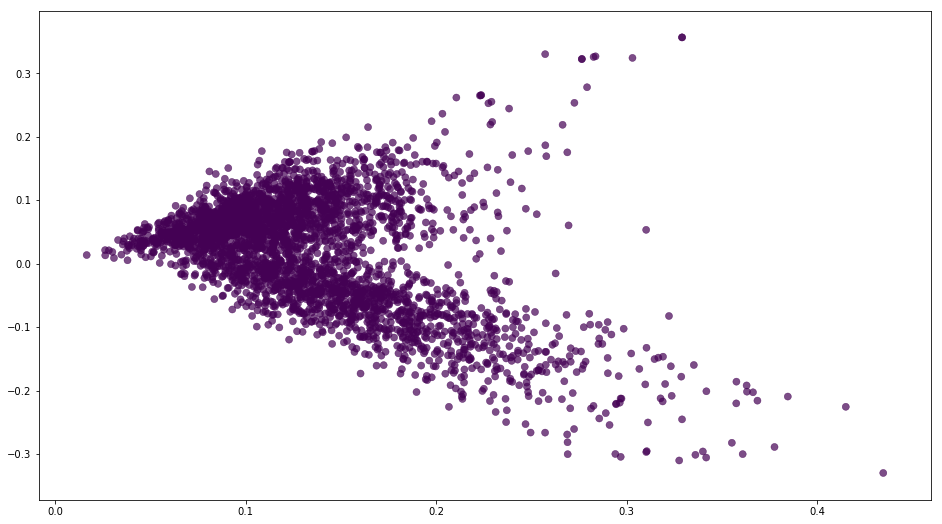

In [134]:
start_time = time.time()
model = DBSCAN(eps=0.1, min_samples=20, algorithm="brute", metric="cosine")
model.fit(X_train_preprocess)
end_time = time.time()
print("Trained DBSCAN model in {} Seconds".format(end_time - start_time))
print("#of labels {},\nlabels:{}".format(len(set(model.labels_)), model.labels_))
visualizeCluster(X_train_preprocess[:, 0], X_train_preprocess[:, 1], colors = model.labels_)

Trained DBSCAN model in 8.580349445343018 Seconds
#of labels 2,
labels:[0 0 0 ... 0 0 0]


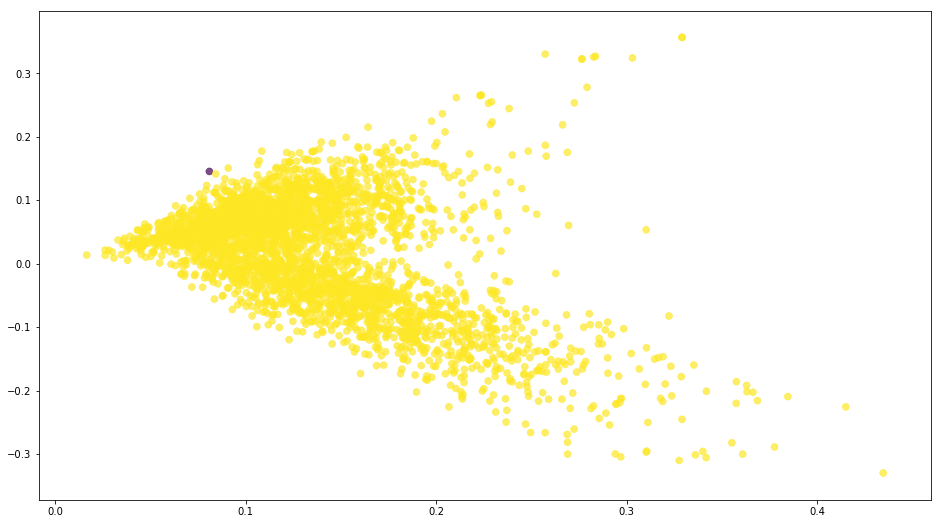

In [133]:
model = DBSCAN(eps=0.001, min_samples=10, algorithm="brute", metric="cosine")
model.fit(X_train_preprocess)
end_time = time.time()
print("Trained DBSCAN model in {} Seconds".format(end_time - start_time))
print("#of labels {},\nlabels:{}".format(len(set(model.labels_)), model.labels_))
visualizeCluster(X_train_preprocess[:, 0], X_train_preprocess[:, 1], colors = model.labels_)

### 直接用DBSCAN出来的效果并不好，维度灾难
试一下hdbscan的效果

Trained DBSCAN model in 0.07818198204040527 Seconds
#of labels 9,
labels:[6 6 6 ... 6 6 6]


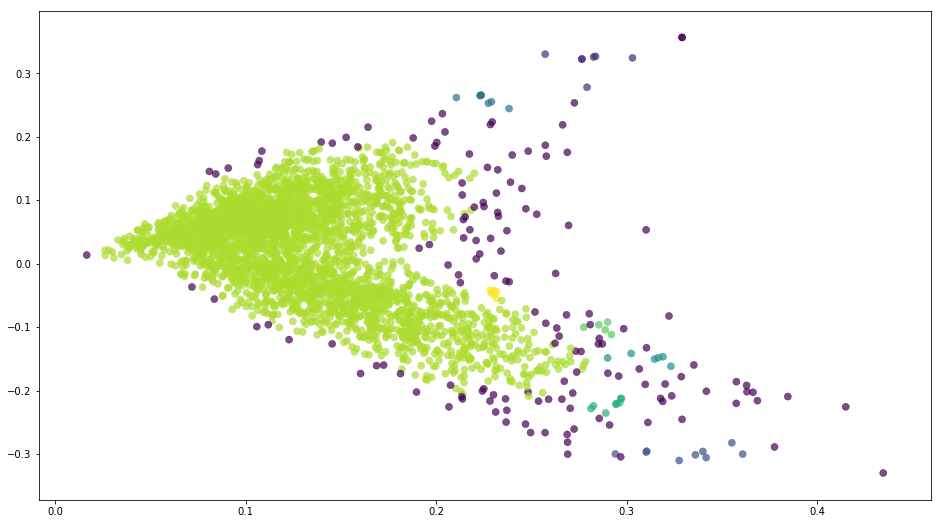

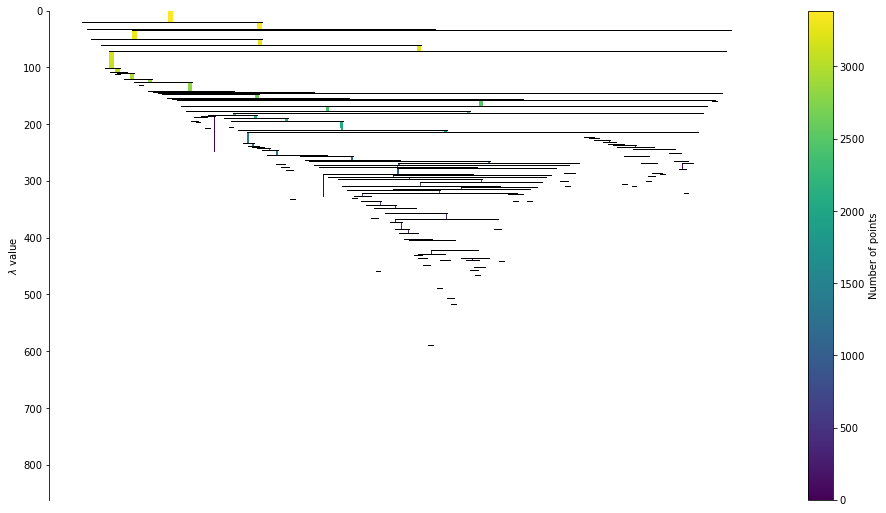

In [132]:
###########Training mode2 1:hdbscan

start_time = time.time()
clusterer = hdbscan.HDBSCAN()
clusterer.fit(X_train_preprocess)
end_time = time.time()
print("Trained DBSCAN model in {} Seconds".format(end_time - start_time))
print("#of labels {},\nlabels:{}".format(len(set(clusterer.labels_)), clusterer.labels_))
visualizeCluster(X_train_preprocess[:, 0], X_train_preprocess[:, 1], colors = clusterer.labels_)
clusterer.condensed_tree_.plot()

In [124]:
print(X_train_preprocess[:10])

[[ 0.16974347 -0.06249747]
 [ 0.11002611  0.08904812]
 [ 0.07785446  0.07680914]
 [ 0.12221636 -0.00949733]
 [ 0.12393194  0.10858281]
 [ 0.14596475  0.14152725]
 [ 0.09294822  0.0443569 ]
 [ 0.15167595  0.091412  ]
 [ 0.18288852  0.15825289]
 [ 0.16472827 -0.05915735]]
